In [1]:
%matplotlib inline
from __future__ import print_function
from collections import defaultdict
import csv
import os
import random
import sys

from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix

import tqdm

In [2]:
from bokeh.charts import Histogram, show
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [3]:
from keras.models import Sequential
from keras.models import model_from_json
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.optimizers import Adagrad, RMSprop, SGD

Using Theano backend.


## Load and Transform Data

In [4]:
def read_batches(filename):
    with open(filename) as in_file:
        reader = csv.reader(in_file)
        for row in reader:
            x = list(map(int, row[:-1]))
#             y = int(row[-1])
            y = max(0, int(row[-1]))
            yield x, y

def BatchGenerator(filename, batch_size=64*1024):
    X = []
    Y = []
    for x, y in read_batches(filename=filename):
        X.append(x)
        Y.append(y)
        if len(Y) == batch_size:
            yield np.array(X), np.array(Y)
            X = []
            Y = []
    if len(Y):
        yield np.array(X), np.array(Y)

In [4]:
g = read_batches("/ssd/train1.csv")
for i in range(0, 5):
    print(next(g))

([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 1)
([1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0], 1)
([2, 2, 0, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 0, 0], 1)
([3, 3, 0, 3, 0, 1, 1, 1, 1, 1, 1, 1, 1, 3, 0, 0, 0], 1)
([4, 4, 0, 4, 0, 1, 1, 1, 1, 1, 1, 1, 1, 4, 0, 0, 0], 1)


## Construct our Neural Network

In [5]:
def construct_NN(activation="relu", exit_act="sigmoid", inner_layers=1,
                 inner_dim=20):
    # Define a Feed Forward NN
    model = Sequential()
    model.add(Dense(input_dim=17, output_dim=inner_dim))
    model.add(Activation(activation))
    for i in range(inner_layers):
        model.add(Dense(input_dim=inner_dim, output_dim=inner_dim))
        model.add(Activation(activation))    
    # Output layer
    model.add(Dense(input_dim=inner_dim, output_dim=1))
    model.add(Activation(exit_act))
    model.compile(loss='mse',
       optimizer=Adagrad(lr=0.01, epsilon=1e-08))    
    return model

In [9]:
def train_model(model, epochs, train_filename, nb_epoch=10,
                batch_size=1024):
    losses = []
    for epoch in tqdm.tqdm(range(epochs)):
        for X_batch, Y_batch in BatchGenerator(train_filename): 
            loss = model.fit(X_batch, Y_batch, batch_size=batch_size, 
                             nb_epoch=nb_epoch, verbose=False,
                             validation_split=0.15,)
            losses.extend(loss.history['loss'])
#             loss = model.train_on_batch(X_batch, Y_batch)
#             losses.append(loss)
    return model, losses

def test_model(model, test_filename):
    accuracies = []

    all_preds = []
    all_y = []
    all_probs = []
    
    for X, y in BatchGenerator(test_filename, batch_size=1024):
        # Model evaluation
        pred_y = model.predict(X, verbose=False)
        preds  = model.predict_classes(X, verbose=False)
        all_preds.extend(preds)
        all_y.extend(y)
        all_probs.extend(list(pred_y))
        acc = accuracy_score(y, preds)
        accuracies.append(acc)
    
    print('CONFUSION MATRIX:\n', confusion_matrix(all_y, all_preds))
    print(len(all_probs))
    all_probs = [x[0] for x in all_probs]
    p = Histogram(np.array(all_probs), title="Predicted p_coop")
    show(p)
    plt.hist(accuracies)
    plt.show()
    print(np.mean(accuracies))
    return np.mean(accuracies)
#     return accuracies

## Train the model

In [ ]:
# # Great but data is bad? (also no normalization)
# epochs = 1

# # train_filename = "/ssd/train1.csv"
# train_filename = "/ssd/archive/train1.csv"
# model = construct_NN(activation="tanh", exit_act="sigmoid",
#                      inner_layers=1, inner_dim=10)
# # model = construct_NN('sigmoid')
# %time model, losses = train_model(model, epochs, train_filename, nb_epoch=1)

# print("MSE", losses[-1])

# plt.plot(range(len(losses)), losses)
# plt.show()

# test_filename = "/ssd/archive/test1.csv"
# accuracies = test_model(model, test_filename)
# plt.hist(accuracies)
# plt.show()
# print(np.mean(accuracies))


100%|██████████| 1/1 [04:24<00:00, 264.52s/it]


MSE 0.0800646690607


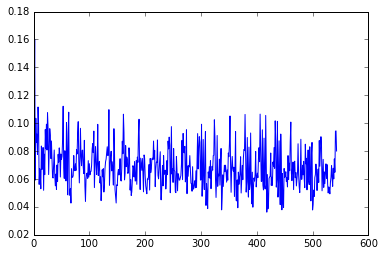

In [10]:
epochs = 1

train_filename = "/ssd/train1.csv"
model = construct_NN(activation="relu", exit_act="sigmoid",
                     inner_layers=1, inner_dim=17)
model, losses = train_model(model, epochs, train_filename, nb_epoch=1)

print("MSE", losses[-1])

plt.plot(range(len(losses)), losses)
plt.show()

## Evaluate the Model

[[ 0.72515184]]
[[1]]
[[ 0.6073423]]
[[1]]
[[ 1.]]
[[1]]
CONFUSION MATRIX:
 [[1204228  134312]
 [ 208761 2017099]]
3564400


/home/user/anaconda3/lib/python3.5/site-packages/bokeh/io.py:350: UserWarning: 

BokehJS does not appear to have successfully loaded. If loading BokehJS from CDN, this
may be due to a slow or bad network connection. Possible fixes:

* ALWAYS run `output_notebook()` in a cell BY ITSELF, AT THE TOP, with no other code
* re-rerun `output_notebook()` to attempt to load from CDN again, or
* use INLINE resources instead, as so:

    from bokeh.resources import INLINE
    output_notebook(resources=INLINE)

  warnings.warn(_NB_LOAD_WARNING)


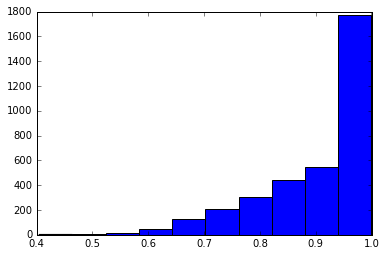

0.903740210657
CPU times: user 1min 41s, sys: 484 ms, total: 1min 42s
Wall time: 1min 42s


0.90374021065655119

In [11]:
X = np.array([[4, 0, 3, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 2, 3, 0, 0]])
# print(model.predict(X, verbose=False))
print(model.predict_proba(X, verbose=False))
print(model.predict_classes(X, verbose=False))

X = np.array([[20,10,10,15,5,0,0,0,0,1,1,1,1,6,5,0,9]])
print(model.predict_proba(X, verbose=False))
print(model.predict_classes(X, verbose=False))

X = np.array([[103,103,0,104,0,0,1,1,1,1,1,1,1,0,1,0,102]])
print(model.predict_proba(X, verbose=False))
print(model.predict_classes(X, verbose=False))

test_filename = "/ssd/test1.csv"
%time test_model(model, test_filename)
# plt.hist(accuracies)
# plt.show()
# print(np.mean(accuracies))


In [12]:
def save_model(model, name):
    # serialize model to JSON
    model_json = model.to_json()
    with open(name + ".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(name + ".h5", overwrite=True)

def load_model(name="model"):
    json_file = open(name + '.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(name + ".h5")
    return loaded_model

In [13]:
save_model(model, "model")

In [ ]:
# save_model(model, "total_prediction_model")

Now we want to train and generate new data iteratively until we win

* Load model
* Train and test
* generate new data
* repeat

In [23]:
model = construct_NN('relu', inner_layers=1, inner_dim=20)
save_model(model, "model")

100%|██████████| 2/2 [01:31<00:00, 45.70s/it]


CPU times: user 1min 31s, sys: 140 ms, total: 1min 31s
Wall time: 1min 31s
MSE 0.230692660999
CONFUSION MATRIX:
 [[ 84787  34793]
 [   656 411764]]
532000


/home/user/anaconda3/lib/python3.5/site-packages/bokeh/io.py:350: UserWarning: 

BokehJS does not appear to have successfully loaded. If loading BokehJS from CDN, this
may be due to a slow or bad network connection. Possible fixes:

* ALWAYS run `output_notebook()` in a cell BY ITSELF, AT THE TOP, with no other code
* re-rerun `output_notebook()` to attempt to load from CDN again, or
* use INLINE resources instead, as so:

    from bokeh.resources import INLINE
    output_notebook(resources=INLINE)

  warnings.warn(_NB_LOAD_WARNING)


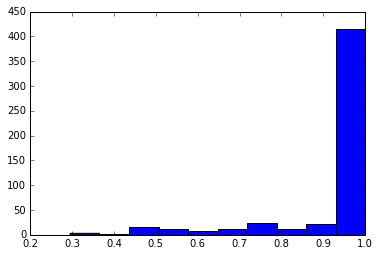

0.933219474689
CPU times: user 1min 55s, sys: 516 ms, total: 1min 55s
Wall time: 1min 55s


In [14]:
from iterative_interactions import create_interactions

epochs = 2

for i in range(0, 5):
    # Generate new data
    create_interactions(str(i))
    # Load
    model = load_model(name="model")    
    model.compile(loss='mse',
       optimizer=Adagrad(lr=0.01, epsilon=1e-08))
    # Train
    train_filename = "/ssd/train_extra.csv{}".format(i)
    %time model, losses = train_model(model, epochs, train_filename, nb_epoch=2)    
    # Test
    print("MSE", losses[-1])
    test_filename = "/ssd/test_extra.csv{}".format(i)
    %time m = test_model(model, test_filename)
    # Save model
    save_model(model, name="model")
    if m > 0.93:
        break
